In [1]:
import os, sys
from datetime import datetime
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = False

from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from IPython.display import display, Image as IPImage, HTML

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x 
KNOWN_FOLDER = r"C:\Users\ADMIN\Desktop\DIP\DIP\known_faces"
TEST_PATH   = r"C:\Users\ADMIN\Desktop\DIP\DIP\test_photo.jpg"

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

if not os.path.isdir(KNOWN_FOLDER):
    print(f"Known folder not found: {KNOWN_FOLDER}")
else:
    print(f"Known folder found with {len(os.listdir(KNOWN_FOLDER))} entries")

if not os.path.isfile(TEST_PATH):
    print(f"Test image not found: {TEST_PATH}")
else:
    print(f"Test image ready: {TEST_PATH}")


Known folder found with 5 entries
Test image ready: C:\Users\ADMIN\Desktop\DIP\DIP\test_photo.jpg


In [2]:
def detect_first_face(img, scaleFactor=1.3, minNeighbors=5):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=scaleFactor,
        minNeighbors=minNeighbors,
        minSize=(30, 30)
    )

    if len(faces) == 0:
        return None

    x, y, w, h = faces[0]
    h_img, w_img = gray.shape
    x1, y1 = max(0, x), max(0, y)
    x2, y2 = min(w_img, x + w), min(h_img, y + h)
    return gray[y1:y2, x1:x2]


def extract_hog_features(face, visualize=False):
    face_resized = cv2.resize(face, (64, 64))

    if visualize:
        feats, hog_image = hog(
            face_resized,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True
        )
        return feats, hog_image

    feats = hog(
        face_resized,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return feats


def show_gray_image(img, title=None, figsize=(3, 3)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if title:
        plt.title(str(title))
    plt.show()


def show_color_image_bgr(img_bgr, title=None, figsize=(6, 4)):
    """
    Display a color image (BGR → RGB) with an optional title.
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.axis('off')
    if title:
        plt.title(str(title))
    plt.show()

print("Helper functions loaded successfully ")

Helper functions loaded successfully 


Loaded test image: C:\Users\ADMIN\Desktop\DIP\DIP\test_photo.jpg
Image shape: (645, 1280, 3)


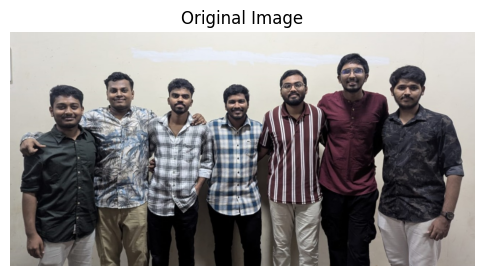

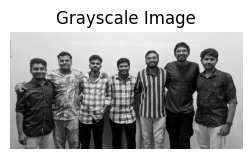

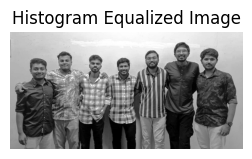

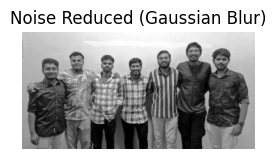

Pre-processing completed — intermediate images saved


In [3]:
# Load test image
image = cv2.imread(TEST_PATH)

if image is None:
    raise FileNotFoundError(f"Could not load image from: {TEST_PATH}")
else:
    print(f"Loaded test image: {TEST_PATH}")
    print(f"Image shape: {image.shape}")

# Original image
show_color_image_bgr(image, "Original Image")

# Grayscale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_gray_image(gray, "Grayscale Image")

# Histogram Equalization (contrast enhancement)
equalized = cv2.equalizeHist(gray)
show_gray_image(equalized, "Histogram Equalized Image")

# Gaussian Blur (noise reduction)
blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
show_gray_image(blurred, "Noise Reduced (Gaussian Blur)")

# Save intermediate results for report
cv2.imwrite("1_original.jpg", image)
cv2.imwrite("2_grayscale.jpg", gray)
cv2.imwrite("3_equalized.jpg", equalized)
cv2.imwrite("4_blurred.jpg", blurred)

print("Pre-processing completed — intermediate images saved")

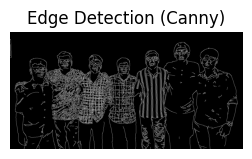

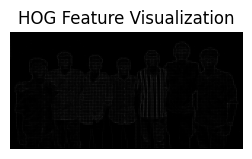

Edge and HOG feature visualizations completed — features shape: (452196,)


In [4]:
# Edge Detection (Canny)
edges = cv2.Canny(gray, 100, 200)
show_gray_image(edges, "Edge Detection (Canny)")

cv2.imwrite("5_edges.jpg", edges)

# HOG (Histogram of Oriented Gradients)
from skimage.feature import hog
from skimage import color, exposure

# Convert to grayscale and normalize for skimage
gray_rescaled = color.rgb2gray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Extract HOG features and visualization
features, hog_img = hog(
    gray_rescaled,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

# Improve contrast for display
hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

# Show HOG visualization
show_gray_image(hog_img_rescaled, "HOG Feature Visualization")

# Save HOG image
cv2.imwrite("6_hog_visualization.jpg", (hog_img_rescaled * 255).astype(np.uint8))

print(f"Edge and HOG feature visualizations completed — features shape: {features.shape}")

People found (5): ['Datta', 'Jaganath', 'Raghu', 'Swami', 'Vishnu']
[1] Loading: C:\Users\ADMIN\Desktop\DIP\DIP\known_faces\Datta\1.jpg


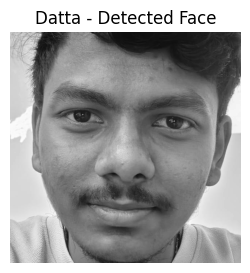

[2] Loading: C:\Users\ADMIN\Desktop\DIP\DIP\known_faces\Jaganath\1.jpg


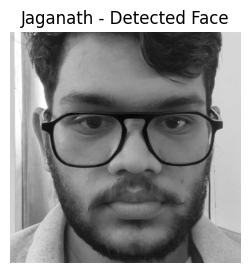

[3] Loading: C:\Users\ADMIN\Desktop\DIP\DIP\known_faces\Raghu\1.jpg


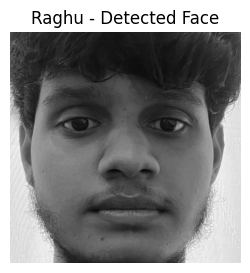

[4] Loading: C:\Users\ADMIN\Desktop\DIP\DIP\known_faces\Swami\1.jpg


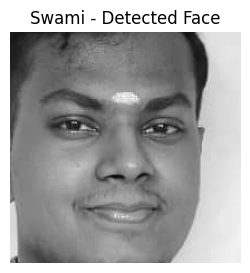

[5] Loading: C:\Users\ADMIN\Desktop\DIP\DIP\known_faces\Vishnu\1.jpg


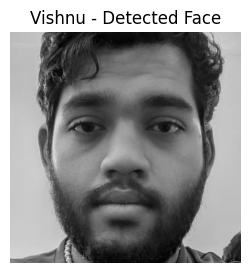

Dataset inspection completed — sample outputs saved


In [5]:
# Verify dataset folder
if not os.path.isdir(KNOWN_FOLDER):
    raise FileNotFoundError(f"Known faces folder not found: {KNOWN_FOLDER}")

# List all subfolders (each person)
people = [d for d in os.listdir(KNOWN_FOLDER) if os.path.isdir(os.path.join(KNOWN_FOLDER, d))]
print(f"People found ({len(people)}): {people}")

# Collect up to 6 example images (first image per person)
examples = []
for person in people:
    person_folder = os.path.join(KNOWN_FOLDER, person)
    files = [f for f in os.listdir(person_folder) if os.path.isfile(os.path.join(person_folder, f))]
    if not files:
        print(f"No images found for {person}")
        continue
    examples.append((person, os.path.join(person_folder, files[0])))

# Display detected faces or full images (up to 6)
for i, (person, path) in enumerate(examples[:6], 1):
    print(f"[{i}] Loading:", path)
    img = cv2.imread(path)
    if img is None:
        print("  -> Cannot read file:", path)
        continue

    face = detect_first_face(img)
    if face is None:
        print("  -> No face detected in:", path)
        show_color_image_bgr(img, f"{person} - Full Image (No Face Detected)")
        cv2.imwrite(f"sample_full_{person}.jpg", img)
    else:
        show_gray_image(face, f"{person} - Detected Face")
        cv2.imwrite(f"sample_face_{person}.jpg", face)

print("Dataset inspection completed — sample outputs saved")


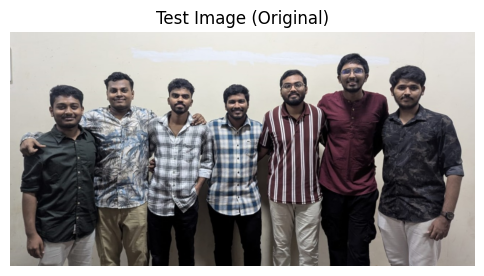

Faces detected: 7


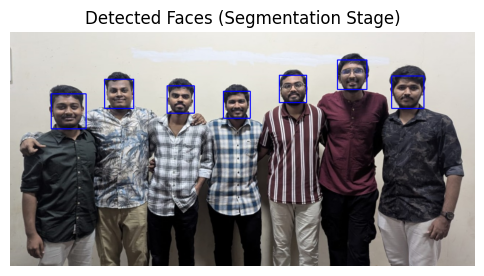

Segmentation stage complete — detected faces saved ✅


In [6]:
# Load the test image
test_img_bgr = cv2.imread(TEST_PATH)
if test_img_bgr is None:
    raise FileNotFoundError(f"Cannot load test image: {TEST_PATH}")

show_color_image_bgr(test_img_bgr, "Test Image (Original)")

# Convert to grayscale for detection
gray = cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2GRAY)

# Detect faces using Haar Cascade
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
print(f"Faces detected: {len(faces)}")

# Draw bounding boxes
img_detected = test_img_bgr.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(img_detected, (x, y), (x + w, y + h), (255, 0, 0), 2)

show_color_image_bgr(img_detected, "Detected Faces (Segmentation Stage)")

# Save intermediate result
cv2.imwrite("7_faces_detected.jpg", img_detected)
print("Segmentation stage complete — detected faces saved ✅")


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]



Extracted 16 feature vectors for 5 people
Sample errors (first 5): []


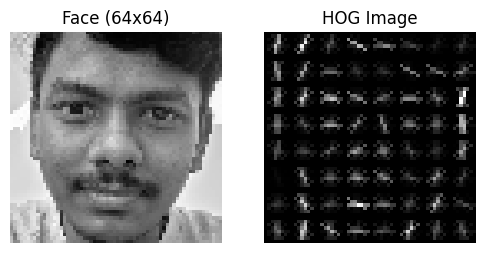

In [7]:
X, y, errors = [], [], []

for person in tqdm(people):
    person_folder = os.path.join(KNOWN_FOLDER, person)
    for filename in os.listdir(person_folder):
        path = os.path.join(person_folder, filename)
        img = cv2.imread(path)
        if img is None:
            errors.append(("read_error", path))
            continue

        face = detect_first_face(img)
        if face is None:
            errors.append(("no_face", path))
            continue

        try:
            feats = extract_hog_features(face)
            X.append(feats)
            y.append(person)
        except Exception as e:
            errors.append(("hog_error", path, str(e)))

print(f"\nExtracted {len(X)} feature vectors for {len(set(y))} people")
print("Sample errors (first 5):", errors[:5])

# Visualize one example face + its HOG pattern
if X:
    example_img = cv2.imread(examples[0][1])
    face_crop = detect_first_face(example_img)
    feats, hog_img = extract_hog_features(cv2.resize(face_crop, (64, 64)), visualize=True)
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Face (64x64)")
    plt.imshow(cv2.resize(face_crop, (64, 64)), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("HOG Image")
    plt.imshow(hog_img, cmap='gray')
    plt.axis('off')
    plt.show()


In [8]:
from collections import Counter

if len(X) == 0:
    raise RuntimeError("No training data found. Check known_faces folder.")

X = np.array(X)
y = np.array(y)
print("Class distribution:", Counter(y))

clf = make_pipeline(StandardScaler(), SVC(kernel="linear", probability=True))
clf.fit(X, y)
print(f"SVM trained successfully for {len(set(y))} classes")

# Quick self-check (training accuracy)
pred_train = clf.predict(X)
acc = np.mean(pred_train == y)
print(f"Training accuracy (optimistic): {acc:.3f}")


Class distribution: Counter({'Swami': 5, 'Vishnu': 4, 'Datta': 3, 'Jaganath': 2, 'Raghu': 2})
SVM trained successfully for 5 classes
Training accuracy (optimistic): 1.000


7 faces detected in test image.
Face 1: predicted=Datta, prob=0.639


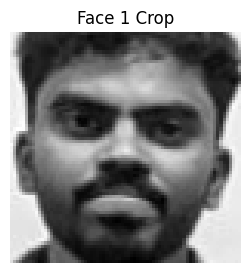

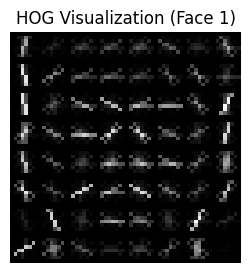

Face 2: predicted=Datta, prob=0.411


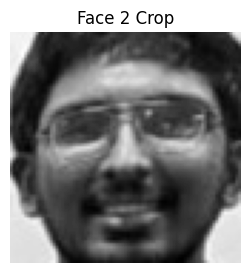

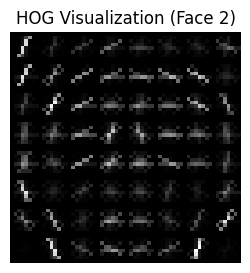

Face 3: predicted=Swami, prob=0.397


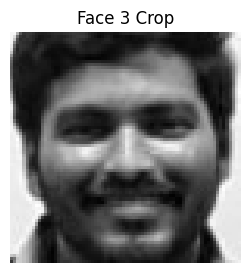

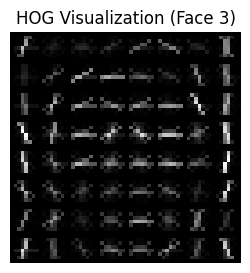

Face 4: predicted=Swami, prob=0.554


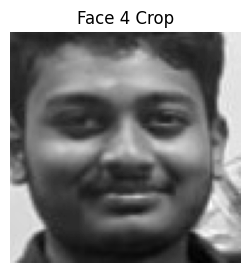

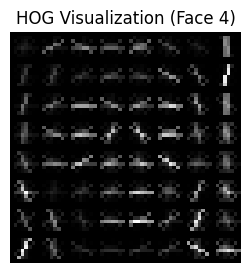

Face 5: predicted=Swami, prob=0.576


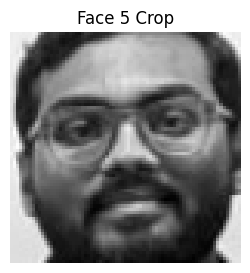

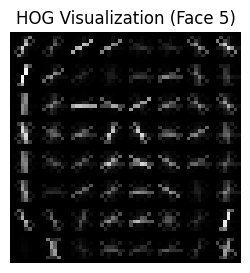

Face 6: predicted=Datta, prob=0.727


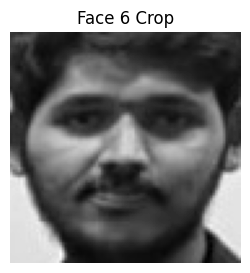

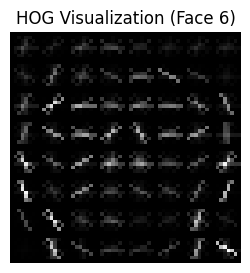

Face 7: predicted=Swami, prob=0.764


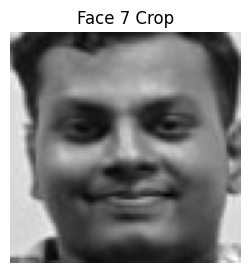

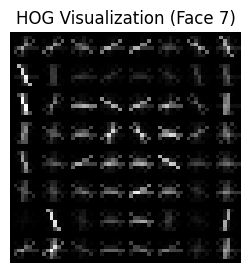

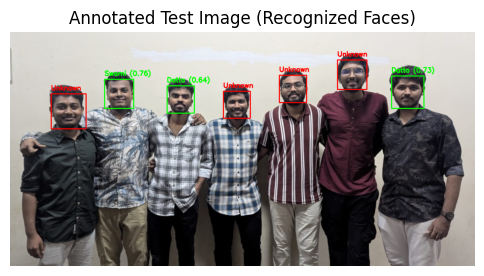

Annotated test image saved


In [9]:
gray = cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(f"{len(faces)} faces detected in test image.")

recognized_names = []
for i, (x, y, w, h) in enumerate(faces, start=1):
    x1, y1 = max(0, x), max(0, y)
    x2, y2 = min(gray.shape[1], x + w), min(gray.shape[0], y + h)
    face_gray = gray[y1:y2, x1:x2]

    if face_gray.size == 0:
        print(f"Face {i} invalid crop, skipping.")
        continue

    feats = extract_hog_features(face_gray).reshape(1, -1)
    pred_name = clf.predict(feats)[0]
    pred_prob = clf.predict_proba(feats).max()
    recognized_names.append(pred_name if pred_prob > 0.6 else "Unknown")

    print(f"Face {i}: predicted={pred_name}, prob={pred_prob:.3f}")

    # Show intermediate visualizations
    show_gray_image(face_gray, f"Face {i} Crop")
    _, hog_img = extract_hog_features(face_gray, visualize=True)
    show_gray_image(hog_img, f"HOG Visualization (Face {i})")

    # Draw bounding boxes on image
    color = (0, 255, 0) if pred_prob > 0.6 else (0, 0, 255)
    label = f"{pred_name} ({pred_prob:.2f})" if pred_prob > 0.6 else "Unknown"
    cv2.rectangle(test_img_bgr, (x1, y1), (x2, y2), color, 2)
    cv2.putText(test_img_bgr, label, (x1, max(20, y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Display annotated test image
show_color_image_bgr(test_img_bgr, "Annotated Test Image (Recognized Faces)")
cv2.imwrite("8_test_annotated.jpg", test_img_bgr)
print("Annotated test image saved")

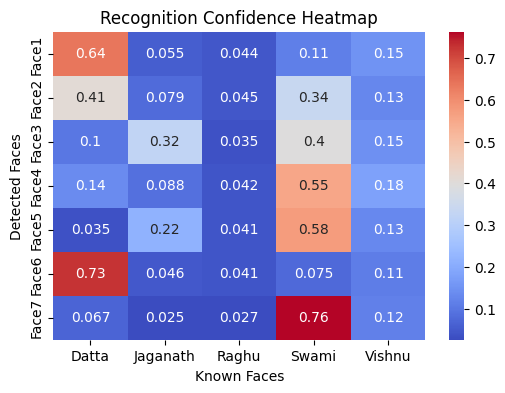

In [10]:
if len(faces) > 0:
    prob_matrix = []
    for (x, y, w, h) in faces:
        face_gray = gray[y:y+h, x:x+w]
        feats = extract_hog_features(face_gray).reshape(1, -1)
        probs = clf.predict_proba(feats)[0]
        prob_matrix.append(probs)

    sns.heatmap(np.array(prob_matrix), annot=True, cmap='coolwarm',
                xticklabels=clf.classes_, yticklabels=[f"Face{i+1}" for i in range(len(prob_matrix))])
    plt.title("Recognition Confidence Heatmap")
    plt.xlabel("Known Faces")
    plt.ylabel("Detected Faces")
    plt.show()
else:
    print("No faces to visualize in heatmap.")


In [11]:
attendance_file = "attendance.csv"
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

if recognized_names:
    df = pd.DataFrame({"Name": recognized_names, "Timestamp": [now] * len(recognized_names)})
    if os.path.exists(attendance_file):
        df.to_csv(attendance_file, mode='a', index=False, header=False)
    else:
        df.to_csv(attendance_file, index=False)
    print(f"Attendance logged for: {recognized_names}")
    display(pd.read_csv("attendance.csv").tail(10))
else:
    print("No recognized faces to save in attendance.")


Attendance logged for: ['Datta', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Datta', 'Swami']


,Name,Timestamp
18,Unknown,2026-01-08 19:15:57
19,Unknown,2026-01-08 19:15:57
20,Unknown,2026-01-08 19:15:57
21,Datta,2026-01-08 19:17:34
22,Unknown,2026-01-08 19:17:34
23,Unknown,2026-01-08 19:17:34
24,Unknown,2026-01-08 19:17:34
25,Unknown,2026-01-08 19:17:34
26,Datta,2026-01-08 19:17:34
27,Swami,2026-01-08 19:17:34


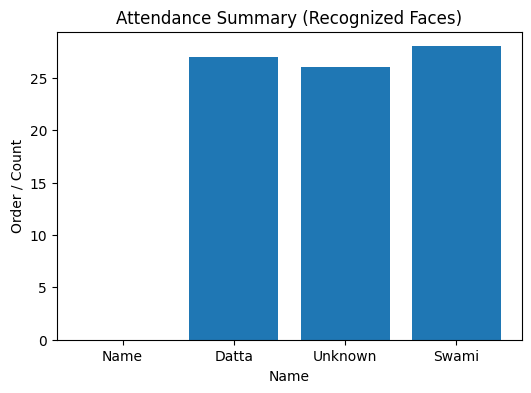

In [12]:
if os.path.exists("attendance.csv"):
    df = pd.read_csv("attendance.csv", header=None, names=["Name", "Timestamp"])
    plt.figure(figsize=(6, 4))
    plt.bar(df["Name"], np.arange(len(df)))
    plt.title("Attendance Summary (Recognized Faces)")
    plt.xlabel("Name")
    plt.ylabel("Order / Count")
    plt.show()
else:
    print("No attendance file found yet.")
